In [1]:
import json
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as ss
import plotly.express as px
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
plt.rcParams['figure.figsize'] = [16, 9]

In [3]:
reviews_df = pd.read_pickle('cleaned_review.pkl')

In [4]:
reviews_df['total_votes'] = reviews_df[['useful', 'funny', 'cool']].sum(axis=1)

In [60]:
reviews_df.shape

(4337534, 14)

In [6]:
reviews = reviews_df.reset_index().set_index('review_id')

In [7]:
reviews.date = pd.to_datetime(reviews.date)

In [8]:
shift_stars = reviews[['stars']].shift(1)
reviews_subset = reviews[['business_id', 'date']].join(shift_stars)

In [9]:
rolling_stars = reviews_subset.groupby('business_id').rolling('180D', on='date').mean()

In [10]:
rolling_stars['stars'] = rolling_stars[['stars']].groupby('business_id').transform(lambda x: x.fillna(x.mean()))

In [11]:
rolling_stars = rolling_stars.reset_index()
reviews_df = reviews_df.reset_index()

In [12]:
rolling_stars.head()

,business_id,review_id,date,stars
0,--164t1nclzzmca7eDiJMw,HcZ2W-oRHgnP6Zs0xYfoUw,2009-03-17,4.025010
1,--164t1nclzzmca7eDiJMw,6kurfVrLY9LuZnH-5GGCgQ,2009-03-24,4.000000
2,--164t1nclzzmca7eDiJMw,eKTlMEpr163ZegnJmHYrqA,2009-03-24,4.000000
3,--164t1nclzzmca7eDiJMw,fvuwn2Aa3SNGeCTlC3O8Ew,2009-03-24,3.666667
4,--164t1nclzzmca7eDiJMw,qUCBZ2I5Cuf3J4Yzn5k21g,2009-05-15,3.000000


In [13]:
# merge the rolling_stars['stars'] with the reviews_df['stars']
reviews_df['prev6M_rating'] = rolling_stars['stars']
reviews_df.head()

,business_id,review_id,user_id,stars,useful,funny,cool,text,date,total_votes,prev6M_rating
0,--164t1nclzzmca7eDiJMw,HcZ2W-oRHgnP6Zs0xYfoUw,InDrrRvQ9f732YGPX4Ixmg,4.0,9,11,10,I don't want to give away too much since it wa...,2009-03-17,30,4.025010
1,--164t1nclzzmca7eDiJMw,6kurfVrLY9LuZnH-5GGCgQ,iktHs9VX9xK4dJW9szxRBA,4.0,1,0,1,"Yum, yum. Good food, big portions and nice pri...",2009-03-24,2,4.000000
2,--164t1nclzzmca7eDiJMw,eKTlMEpr163ZegnJmHYrqA,InDrrRvQ9f732YGPX4Ixmg,3.0,5,5,4,"Well, after one day at the South Congress loca...",2009-03-24,14,4.000000
3,--164t1nclzzmca7eDiJMw,fvuwn2Aa3SNGeCTlC3O8Ew,nHnNraNUct25HJJTRAGYkA,1.0,2,2,2,Me So Hungry earns 1 star because the owner's ...,2009-03-24,6,3.666667
4,--164t1nclzzmca7eDiJMw,qUCBZ2I5Cuf3J4Yzn5k21g,18_WSz4VPqieDzBsSvCMmA,5.0,1,0,0,I work across the street from Me So Hungry and...,2009-05-15,1,3.000000


In [14]:
temp = rolling_stars.groupby('business_id').rolling('180D', on='date').count()

In [15]:
reviews_df['prev6M_count'] = temp.drop(columns='business_id').reset_index().stars - 1

In [16]:
reviews_df.head()

,business_id,review_id,user_id,stars,useful,funny,cool,text,date,total_votes,prev6M_rating,prev6M_count
0,--164t1nclzzmca7eDiJMw,HcZ2W-oRHgnP6Zs0xYfoUw,InDrrRvQ9f732YGPX4Ixmg,4.0,9,11,10,I don't want to give away too much since it wa...,2009-03-17,30,4.025010,0.0
1,--164t1nclzzmca7eDiJMw,6kurfVrLY9LuZnH-5GGCgQ,iktHs9VX9xK4dJW9szxRBA,4.0,1,0,1,"Yum, yum. Good food, big portions and nice pri...",2009-03-24,2,4.000000,1.0
2,--164t1nclzzmca7eDiJMw,eKTlMEpr163ZegnJmHYrqA,InDrrRvQ9f732YGPX4Ixmg,3.0,5,5,4,"Well, after one day at the South Congress loca...",2009-03-24,14,4.000000,2.0
3,--164t1nclzzmca7eDiJMw,fvuwn2Aa3SNGeCTlC3O8Ew,nHnNraNUct25HJJTRAGYkA,1.0,2,2,2,Me So Hungry earns 1 star because the owner's ...,2009-03-24,6,3.666667,3.0
4,--164t1nclzzmca7eDiJMw,qUCBZ2I5Cuf3J4Yzn5k21g,18_WSz4VPqieDzBsSvCMmA,5.0,1,0,0,I work across the street from Me So Hungry and...,2009-05-15,1,3.000000,4.0


In [35]:
# summarize based on a forward-looking window
subset1 = reviews_df[['business_id', 'date', 'review_id', 'stars']]
subset1['date'] = pd.to_datetime(subset1['date'])
subset1 = subset1.set_index(['business_id', 'date', 'review_id'])

<ipython-input-35-86bd8d2fe144>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset1['date'] = pd.to_datetime(subset1['date'])


In [37]:
# Ended up using a rather crude way 
# doing it based on actual date takes a long time - but can be worked on in the future
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=20)
subset1_forward = subset1.groupby('business_id').rolling(window=indexer, min_periods=1).mean()

In [56]:
reviews_df['projected6M_rating'] = subset1_forward.reset_index().stars
reviews_df.head()

,business_id,review_id,user_id,stars,useful,funny,cool,text,date,total_votes,prev6M_rating,prev6M_count,projected6M_rating
0,--164t1nclzzmca7eDiJMw,HcZ2W-oRHgnP6Zs0xYfoUw,InDrrRvQ9f732YGPX4Ixmg,4.0,9,11,10,I don't want to give away too much since it wa...,2009-03-17,30,4.025010,0.0,4.40
1,--164t1nclzzmca7eDiJMw,6kurfVrLY9LuZnH-5GGCgQ,iktHs9VX9xK4dJW9szxRBA,4.0,1,0,1,"Yum, yum. Good food, big portions and nice pri...",2009-03-24,2,4.000000,1.0,4.45
2,--164t1nclzzmca7eDiJMw,eKTlMEpr163ZegnJmHYrqA,InDrrRvQ9f732YGPX4Ixmg,3.0,5,5,4,"Well, after one day at the South Congress loca...",2009-03-24,14,4.000000,2.0,4.50
3,--164t1nclzzmca7eDiJMw,fvuwn2Aa3SNGeCTlC3O8Ew,nHnNraNUct25HJJTRAGYkA,1.0,2,2,2,Me So Hungry earns 1 star because the owner's ...,2009-03-24,6,3.666667,3.0,4.55
4,--164t1nclzzmca7eDiJMw,qUCBZ2I5Cuf3J4Yzn5k21g,18_WSz4VPqieDzBsSvCMmA,5.0,1,0,0,I work across the street from Me So Hungry and...,2009-05-15,1,3.000000,4.0,4.75


In [57]:
reviews_df.to_pickle('rollingDataIncluded.pkl')

In [59]:
sia = SentimentIntensityAnalyzer()
reviews_df['polarity_score'] = reviews_df['text'].map(sia.polarity_scores, na_action='ignore')

In [62]:
reviews_df.to_pickle('withPolarityScore.pkl')

In [2]:
reviews_df = pd.read_pickle('withPolarityScore.pkl')

In [3]:
reviews_df.head()

,business_id,review_id,user_id,stars,useful,funny,cool,text,date,total_votes,prev6M_rating,prev6M_count,projected6M_rating,polarity_score
0,--164t1nclzzmca7eDiJMw,HcZ2W-oRHgnP6Zs0xYfoUw,InDrrRvQ9f732YGPX4Ixmg,4.0,9,11,10,I don't want to give away too much since it wa...,2009-03-17,30,4.025010,0.0,4.40,"{'neg': 0.048, 'neu': 0.856, 'pos': 0.096, 'co..."
1,--164t1nclzzmca7eDiJMw,6kurfVrLY9LuZnH-5GGCgQ,iktHs9VX9xK4dJW9szxRBA,4.0,1,0,1,"Yum, yum. Good food, big portions and nice pri...",2009-03-24,2,4.000000,1.0,4.45,"{'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'comp..."
2,--164t1nclzzmca7eDiJMw,eKTlMEpr163ZegnJmHYrqA,InDrrRvQ9f732YGPX4Ixmg,3.0,5,5,4,"Well, after one day at the South Congress loca...",2009-03-24,14,4.000000,2.0,4.50,"{'neg': 0.061, 'neu': 0.772, 'pos': 0.167, 'co..."
3,--164t1nclzzmca7eDiJMw,fvuwn2Aa3SNGeCTlC3O8Ew,nHnNraNUct25HJJTRAGYkA,1.0,2,2,2,Me So Hungry earns 1 star because the owner's ...,2009-03-24,6,3.666667,3.0,4.55,"{'neg': 0.043, 'neu': 0.786, 'pos': 0.171, 'co..."
4,--164t1nclzzmca7eDiJMw,qUCBZ2I5Cuf3J4Yzn5k21g,18_WSz4VPqieDzBsSvCMmA,5.0,1,0,0,I work across the street from Me So Hungry and...,2009-05-15,1,3.000000,4.0,4.75,"{'neg': 0.0, 'neu': 0.776, 'pos': 0.224, 'comp..."


In [4]:
reviews_df['compound'] = reviews_df[['polarity_score']].applymap(lambda x: x['compound'], na_action='ignore')
reviews_df['neg'] = reviews_df[['polarity_score']].applymap(lambda x: x['neg'], na_action='ignore')
reviews_df['neu'] = reviews_df[['polarity_score']].applymap(lambda x: x['neu'], na_action='ignore')
reviews_df['pos'] = reviews_df[['polarity_score']].applymap(lambda x: x['pos'], na_action='ignore')

In [5]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

In [73]:
# need to label businesses
from sklearn import preprocessing

In [74]:
le = preprocessing.LabelEncoder()
le.fit(reviews_df['business_id'])
reviews_df['business_encoded'] = le.transform(reviews_df['business_id'])

In [7]:
training_data = reviews_df[['stars', 'total_votes', 'compound','prev6M_rating', 'prev6M_count',
                           'neg', 'neu', 'pos']]

testing_data = reviews_df['projected6M_rating'].values

In [8]:
# implement k fold cross_val yourself
score_list = []
feature_importances = []

for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(training_data, testing_data)
    reg = GradientBoostingRegressor()
    reg.fit(X_train, y_train)
    curr_score = reg.score(X_test, y_test)
    score_list.append(curr_score)
    feature_importances.append(reg.feature_importances_)


In [13]:
score_list

[0.6183698673649892,
 0.6193854812198178,
 0.6188080672891775,
 0.6186855584085211,
 0.6195803709158352]

In [15]:
fi = feature_importances[4]

<BarContainer object of 8 artists>

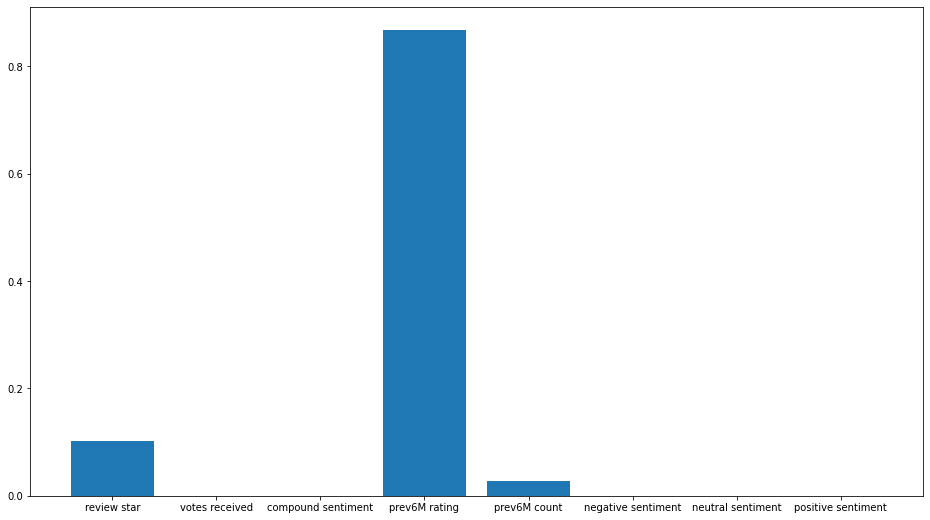

In [29]:
plt.bar(x =np.arange(0, 8) ,height =feature_importances[4], tick_label=['review star', 'votes received', 'compound sentiment', 'prev6M rating', 'prev6M count',
                           'negative sentiment', 'neutral sentiment', 'positive sentiment'])
#plt.ylabel('Feature importance')
#plt.xlabel('Features')

In [28]:
plt.rcParams['figure.figsize'] = [16, 9]